# Computer Vision Assignment 2
---

Semester: **Fall 2022**

Due date: **October 27th 2022, 11.59PM EST.**

## Instructions
---

You should perform this assignment using Google Colab. 
* Before starting, clone this assignment using `File > Save a copy in Drive`. 
* After you're done, go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on brightspace


## Introduction
---

This is a minimal notebook showing the basics of object detection using ~300 lines of code. In this assignment you will code an object detection network with functionality similiar to a Single Shot (or YOLO) detector.
 
For our purposes, we shall divide each image into rectangular crops called anchors. The job of our object detector is to classify each anchor as containing an object or not. If the anchor contains an object, we want to find out the change in the anchor position and size to best fit the object in it. Hence, object detection is a multi task network which does classification and regression.

In [2]:
# load helper code
%cd /content
!rm -rf nyu-cv-object-detection
!git clone https://github.com/nikhilweee/nyu-cv-object-detection
%cd nyu-cv-object-detection

/content
Cloning into 'nyu-cv-object-detection'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
/content/nyu-cv-object-detection


In [3]:
import torch
import matplotlib
import torch.nn as nn
import torch.nn.functional as F

from utils.plot import visualize
from utils.encoder import ResNet18Encoder
from utils.dataset import get_dataloaders
from torchvision.ops import box_iou, nms
 
trainloader, valloader = get_dataloaders(batch_size=4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Dataset
---

First, let's introduce our dataset. We shall work with an artificially generated dataset of different shapes (squares, triangles and circles) spread throughout an image. We have a Pytorch dataloader which outputs a `sample` and `target` pair. The `sample` contains the image and the `target` contains information about the bounding boxes. We have visualized the dataset below. You dont need to write any code here. However, feel free to dig into the functions that are called to better understand the structure of the dataset. 

In [64]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample, dim=0)

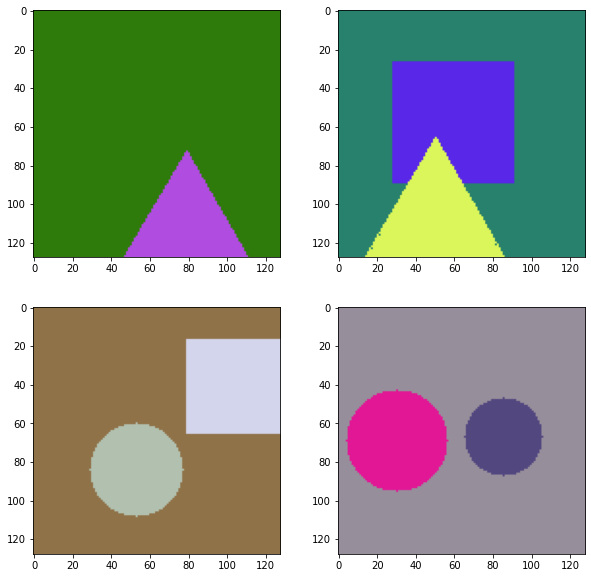

In [65]:
visualize(sample)

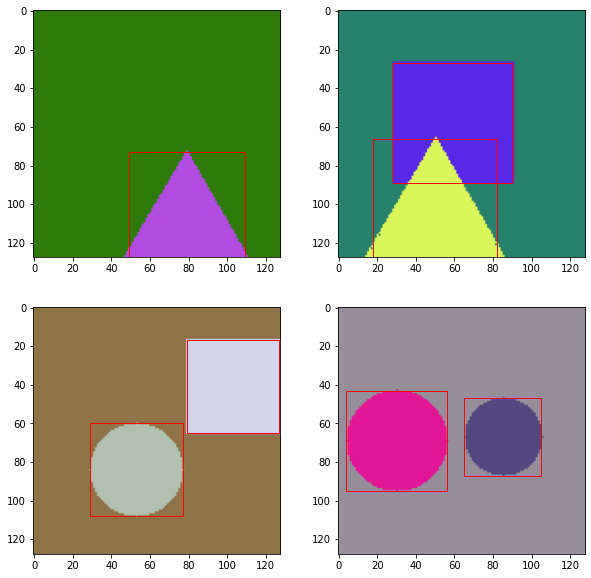

In [66]:
visualize(sample, target)

## Targets
---

The labels (or `target`s) for each `sample` in the dataset have 2 kinds of information.

1. The bounding boxes which are a tensor of size (N x 4).  
Here is N is the number of objects in the image and 4 corresponds to:

  a. top left x coordinate  
  b. top left y coordinate  
  c. bottom right x coordinate  
  d. bottom right y coordinate  

2. The classification labels which are a tensor of size (N x 1).  
Here N corresponds to the number of objects in the image.  
The 1 corresponds to the label of the object (whether it is a triangle, square or circle).

For your convenience, here's what a `target` looks like.


In [12]:
# len(target) how many images
# target[i] 
# labels: 1=> sqaure 2=> circle 3=> rectangle
# class: 0=>background ...
print(target[3])

{'bounding_box': tensor([[ 40,  38, 102, 100],
        [ 76,  45, 138, 107],
        [ 45,   4,  87,  46]]), 'labels': tensor([3, 3, 2], dtype=torch.int32)}


## TODO 1 [20%]: Anchors
---

As described before, our object detection network heavily builds upon the concept of anchors. Each image is divided into equally spaced rectangles of different sizes. These rectangles are called anchors. Anchors are best explained through this image.

![Anchor Boxes](https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png)

Our synthetic dataset has images of size 128x128. We shall divide the image into anchors of three different sizes - 40x40, 50x50 and 60x60. We shall use a stride length of 16, which is to say that two anchors of the same size will be separated by 16 pixels (horizontally and vertically). Keeping this in mind, we shall have 64 anchors (128/16 = 8 anchors horizontally and 128/16 = 8 anchors vertically) corresponding to each size. Since we are working with three different sizes, the image will be divided into 64x3 = 192 anchors.

Your first job is to write the code that creates these 192 anchors from an image of size 128x128. Each anchor will be represented by a 4-tuple (top left x, top left y, bottom right x, bottom right y). Therefore, the output of the function below should be a tensor of size `[192,4]`


In [13]:
def get_anchors():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a torch tensor of size [192,4]
    """
    stride = 16
    image_size = 128
    scales = [40, 50, 60]
    
    anchors = []

    # TODO: Generate anchors
    '''
    0 --------> X
    |
    |
    |
    V
    Y
    Calculate the positions of a anchor
    the center of the anchor is the center of the block 16 * 16
    iterate from topleft of each block
    '''
    feature_size = image_size//stride # 8
    for i in range(feature_size):
      for j in range(feature_size):
        for sc in scales:
          tl_x = i * stride - (sc - stride) * 0.5
          tl_y = j * stride - (sc - stride) * 0.5
          br_x = i * stride + stride + (sc - stride) * 0.5
          br_y = j * stride + stride + (sc - stride) * 0.5
          anchors.append([tl_x, tl_y, br_x, br_y])
    anchors = torch.tensor(anchors)
    return anchors

anchors = get_anchors()
assert anchors.size() == (192,4)

## TODO 2 [10%]: Model
---

Our object detection model will consist of two 'heads'. Both heads will process each of the 192 anchors that you generated in the previous section. The two heads are:

1. A **classification head** (`cls` layer in the picture) to detect whether the anchor has an object in it or not. This is done by measuring the IOU of the anchor with each of the bounding boxes from the `target`. If the IOU is > 0.7, we say that the chunk contains the object. If it is less than 0.3, we say the chunk only contains the background. If the value is somewhere in between, we say that it is a bad chunk and do not use it towards loss computation.

2. A **regression head** (`reg` layer in the picture) to calculate the change in height, width and the centre coordinates of the anchor to best fit the object. These offsets are 4 values for the height, width, center x and y coordinates.

A pictorial representation of the model is shown below. However, instead of `2k` in the given image we just have k scores for the `cls` layer. This is because we group triangles, squares and circles into one foreground class for this assignment. Of course, we can have seperate predictions for each class but that is added complexity and is not implemented here.

![Model Architecture](https://cdn-images-1.medium.com/max/1600/1*7heX-no7cdqllky-GwGBfQ.png)


Your next job is to construct the model. Most of it is already implemented, you just have to add the classification and regression heads.

In [14]:
class ShapesModel(nn.Module):

    def __init__(self):
        super().__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 18 encoder
        self.encoder = ResNet18Encoder()

        # a small conv net
        self.conv = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # TODO: Add a convolutional Layer to predict the class. This is a head that predicts whether an anchor contains an object or not.
        self.cls = nn.Conv2d(256, num_anchors, kernel_size=1)

        # TODO: Add a convolutional Layer to predict the offsets. This is a regression head that calculates 4 offsets for each anchor.
        self.reg = nn.Conv2d(256, num_anchors * 4, kernel_size=1)


    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function

        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)

        return layer


    def post_process(self, cls_pred, reg_pred):
        # helper function that gets outputs in the right shape for applying the loss

        N, AxC, H, W = cls_pred.size()
        Ax4 = reg_pred.size(1)

        A = Ax4 // 4
        C = AxC // A

        cls_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )

        reg_pred = self.permute_and_flatten(
            reg_pred, N, A, 4, H, W
        )

        return cls_pred.squeeze(), reg_pred.squeeze()


    def forward(self, x):

        x = self.encoder(x)

        # we take the 3rd output feature map of 
        # size 8 x 8 from the resnet18 encoder 

        x = x[3]

        x = F.relu(self.conv(x))

        cls_pred = self.cls(x)
        reg_pred = self.reg(x)

        cls_pred, reg_pred = self.post_process(cls_pred, reg_pred)

        return cls_pred, reg_pred


In [15]:
model = ShapesModel()
sample, target = iter(trainloader).next()
sample = torch.stack(sample, dim=0)
cls_pred, reg_pred = model(sample)

assert cls_pred.size() == (4, 192) and reg_pred.size() == (4, 192, 4)

## TODO 3 [15%]: Preprocess
---

Now that we know how our model works, we need to prepare our dataset so that it can be used to train our model. Recall that our dataset provides bounding boxes and labels for each image. However, our model expects a class label and regression offsets for each anchor. In the following cells, you will implement `get_labels_and_offsets`, which calculates class labels and offsets for each anchor.

Offsets are calculated in case the anchor has an IOU > 0.7 with any real object. The offsets are calculated using `compute_offsets`, which has already been provided to you. You may also need to use [`torchvision.ops.box_iou`](https://pytorch.org/vision/main/generated/torchvision.ops.box_iou.html).

In [ ]:
# target [:, :]. [x1, y1, x2, y2] for a box

In [16]:
def compute_offsets(targets, anchors):
    """
    This function returns the offsets that need to applied to anchors to morph them into targets.
    Both anchors and targets should be of the same shape, N x 4.
    The output would be offsets given in a torch tensor of size N x 4.
    """

    t_width = targets[:, 2] - targets[:, 0]
    t_height = targets[:, 3] - targets[:, 1]
    t_center_x = targets[:, 0] + 0.5 * t_width
    t_center_y = targets[:, 1] + 0.5 * t_height

    a_width = anchors[:, 2] - anchors[:, 0]
    a_height = anchors[:, 3] - anchors[:, 1]
    a_center_x = anchors[:, 0] + 0.5 * a_width
    a_center_y = anchors[:, 1] + 0.5 * a_height

    delta_x = (a_center_x - t_center_x) / t_width
    delta_y = (a_center_y - t_center_y) / t_height
    delta_scale_x = torch.log(a_width / t_width)
    delta_scale_y = torch.log(a_height / t_height)

    offsets = torch.cat(
        [
            delta_x.unsqueeze(0),
            delta_y.unsqueeze(0),
            delta_scale_x.unsqueeze(0),
            delta_scale_y.unsqueeze(0),
        ],
        dim=0,
    )
    return offsets.permute(1, 0)

In [17]:
def get_labels_and_offsets(targets, anchors):
    '''
    INPUT:
    targets: [N x 4]: Bounding boxes in the image.
    anchors: [192 x 4]: Anchor boxes of an image. 

    OUTPUT: 
    labels: [192 x 1]: Class labels for each anchor. 1 is for foreground, 0 is for background and -1 is for a bad anchor.
    offsets: [192 x 4]: Offsets for anchor to best fit the bounding box object. Calculated if class label is 1.

    '''
    high_threshold = 0.7
    low_threshold = 0.3

    N = anchors.size(0)
    Num_target = targets.size(0) # <== added one more line here
    
    # TODO: Calculate labels and offsets
    offsets = torch.Tensor([[0.,0.,0.,0.] for _ in range(N)])
    labels = torch.Tensor([[0] for _ in range(N)])
  
    def add_label(iou_vec):
        '''
        input: i : the anchors with iou computed
        algo: check if exist anchor has been classified as having an object for any of the targets
        return: labels
        '''
        if any(iou_vec == 1): return 1 # as long as one anchor is 1 then set 1
        elif any(iou_vec== -1): return -1
        else: return 0

    # Calculate the IOU here which is the accuracy of a anchor
    IOU = box_iou(anchors, targets) # one is target, one is anchor

    classify = [[0] * Num_target for _ in range(N)]
    classify = torch.tensor(offsets)
    for i in range(N):
        for j in range(Num_target):
            if IOU[i][j] > 0.7:
                classify[i][j] = 1
                offsets[i] = compute_offsets(targets[j,:].view(-1, 4), anchors[i,:].view(-1,4))
            elif IOU[i][j] < 0.3:
                classify[i][j] = 0
            else:
                classify[i][j] = -1

    # Calculate the labels
    labels = torch.Tensor([add_label(i) for i in classify]).unsqueeze(dim = 1)
    # labels=torch.reshape(labels,(192, 1))
    return labels.squeeze(), offsets.squeeze()



In [18]:
def get_batch(sample, target):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''

    all_labels = []
    all_offsets = []
    
    for s, t in zip(sample, target):
        targets = t['bounding_box'].to(device)
        labels, offsets = get_labels_and_offsets(targets, anchors)
        all_labels.append(labels)
        all_offsets.append(offsets)
    
    all_labels = torch.stack(all_labels, dim=0)
    all_offsets = torch.stack(all_offsets, dim=0)

    return all_labels, all_offsets

In [19]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample, dim=0)

anchors = anchors.to(device) # <== add one more line here
labels, offsets = get_batch(sample, target)
assert labels.size() == (4, 192) and offsets.size() == (4, 192, 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


This is the meat of object detection right there ! A major part of the exercise is the correct calculation of the anchors for an image and its ground truth. Now that this is done, we can move on to our neural network training code.

## TODO 4 [20%]: Loss
---

The two heads in our model will use different losses.

1. The classification head shall use the binary cross entropy loss. The loss is calculated only for those anchors which have been classified as foreground or background (IOU > 0.7 or IOU < 0.3) and should not be calculated for anchors with (0.3 < IOU < 0.7).

Since there are too many background anchors, the model can easily predict `background` for each anchor and still get a high accuracy. To prevent this, we may sample the foreground more frequently (say 3x more than the background). This strategy of sampling less frequent examples more often is called negative sampling. Since we're dealing with relatively small number of anchors (192), this problem shouldn't affect us yet. However, if we were to use more anchors, we would have to be more careful.

2. For the regression head, use a Smooth L1 loss. This works well and prevents outliers. Only calculate this loss when there is a valid offset.

Your next task is to write the code for the two losses. 

**Extra Credit**: Implement negative sampling as described above.


In [ ]:
'''
# TEST 1
import torch
import torch.nn as nn

model = nn.Linear(10, 1)
criterion = nn.BCEWithLogitsLoss()

x = torch.randn(16, 10)
y = torch.empty(16).random_(2)  # (16, )

out = model(x)  # (16, 1)
out = out.squeeze(dim=-1)  # (16, )
print(out)
print(y)

loss = criterion(out, y)
print(loss)
'''

tensor([-0.1434,  0.3568, -0.0344, -0.2670, -0.6615,  0.1206,  0.5887, -0.3257,
        -0.4868,  0.7723,  0.0939,  0.3163,  0.0579,  0.7099, -0.4334,  0.2400],
       grad_fn=<SqueezeBackward1>)
tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor(0.7473, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
'''
criterion = nn.SmoothL1Loss(reduction='none')
loss = criterion(torch.tensor([]), torch.tensor([]))
loss
'''

tensor([])

In [ ]:
'''
# TEST 2
criterion = nn.BCEWithLogitsLoss()
loss = criterion(torch.tensor([]), torch.tensor([]))
loss
'''

tensor(nan)

In [20]:
def label_loss(pred_label, gt_label):
    # TODO return label loss

    pred_label = pred_label.to(device)
    gt_label = gt_label.to(device)

    num_ig = pred_label.size(0)
    num_an = pred_label.size(1)

    criterion = nn.BCEWithLogitsLoss()
    pred_loss, gt_loss = list(), list()

    for i in range(num_ig):
        for j in range(num_an):
            if gt_label[i][j] != -1:
                pred_loss += [pred_label[i][j]]
                gt_loss += [gt_label[i][j]]
    
    pred_loss = torch.stack(pred_loss, dim=0).to(device) if pred_loss else torch.tensor([])
    gt_loss = torch.stack(gt_loss, dim=0).to(device) if gt_loss else torch.tensor([])
    loss = criterion(pred_loss, gt_loss)

    return loss
  

def offset_loss(pred_offset, gt_offset, gt_label):
    # TODO return offset loss

    pred_offset = pred_offset.to(device)
    gt_offset = gt_offset.to(device)
    gt_label = gt_label.to(device)

    num_ig = pred_offset.size(0)
    num_an = pred_offset.size(1)

    criterion = nn.SmoothL1Loss()
    pred_loss, gt_loss = list(), list()

    for i in range(num_ig):
        for j in range(num_an):
            if gt_label[i][j] == 1:
                pred_loss += [pred_offset[i][j]]
                gt_loss += [gt_offset[i][j]]
    
    pred_loss = torch.stack(pred_loss, dim=0).to(device) if pred_loss else torch.tensor([])
    gt_loss = torch.stack(gt_loss, dim=0).to(device) if gt_loss else torch.tensor([])
    loss = criterion(pred_loss, gt_loss) if pred_loss.size(0) and gt_loss.size(0) else torch.tensor(0).to(device)
    
    # pred_loss = torch.stack(pred_loss, dim=0).to(device)
    # gt_loss = torch.stack(gt_loss, dim=0).to(device) 
    # loss = criterion(pred_loss, gt_loss)

    return loss

## TODO 5 [10%]: Training 
---

This is the training function. It is complete in itself, but you're free to change this code to suit your needs. Make sure that your model is able to train well without any hiccups. In particular, we're looking for decreasing loss values without any NaNs.

In [21]:
def train(epoch, model, trainloader, optimizer):
    total_loss = 0
    running_offset_loss = 0
    running_label_loss = 0
    for i, (images, targets) in enumerate(trainloader):
        images = torch.stack(images, dim=0).to(device)
        gt_labels, gt_offsets = get_batch(images, targets)
        pred_labels, pred_offsets = model(images)
        loss_label = label_loss(pred_labels, gt_labels)
        loss_offset = offset_loss(pred_offsets, gt_offsets, gt_labels)
        loss = loss_label + loss_offset

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_label_loss += loss_label.item()
        running_offset_loss += loss_offset.item()

        if (i+1) % 500 == 0:
            print(f'Iter {i+1} | Class Loss: {running_label_loss / (i+1)} Offset Loss: {running_offset_loss / (i+1)}')
        
    avg_running_label_loss = float(running_label_loss / len(trainloader))
    avg_running_offset_loss = float(running_offset_loss / len(trainloader))
    print(f'Epoch: {epoch+1} | Class Loss: {avg_running_label_loss}, Offset Loss: {avg_running_offset_loss} \n')

In [27]:
# TODO: Train your model
lr = 0.1
model = ShapesModel()
model.to(device)
  
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr, momentum=0.9, weight_decay=1e-4
)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-06, weight_decay= 0.0005)
# scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

for epoch in range(5):
    train(epoch, model, trainloader, optimizer)
    # scheduler1.step()
    # scheduler2.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter 500 | Class Loss: 0.072954405374825 Offset Loss: 0.025310263644671066
Iter 1000 | Class Loss: 0.06674232109449804 Offset Loss: 0.014553800351568497
Iter 1500 | Class Loss: 0.06382760206734141 Offset Loss: 0.01087927337080085
Iter 2000 | Class Loss: 0.06153259257785976 Offset Loss: 0.009056273944996064
Iter 2500 | Class Loss: 0.06001211047098041 Offset Loss: 0.007927657575602643
Epoch: 1 | Class Loss: 0.06001211047098041, Offset Loss: 0.007927657575602643 

Iter 500 | Class Loss: 0.05281579536572099 Offset Loss: 0.0033927841130644083
Iter 1000 | Class Loss: 0.05082144012395293 Offset Loss: 0.0033776922753313557
Iter 1500 | Class Loss: 0.04997854169271886 Offset Loss: 0.0033371893883838008
Iter 2000 | Class Loss: 0.0485234553203918 Offset Loss: 0.003300495789531851
Iter 2500 | Class Loss: 0.04630400233156979 Offset Loss: 0.0033630809125723316
Epoch: 2 | Class Loss: 0.04630400233156979, Offset Loss: 0.0033630809125723316 

Iter 500 | Class Loss: 0.03141559004131705 Offset Loss: 0.003

## Validation
---

Now that we have a trained model, let's move on to visualizing some results. First, let's have a look at the validation data.

In [102]:
sample, target = iter(valloader).next()
sample = torch.stack(sample,dim=0)

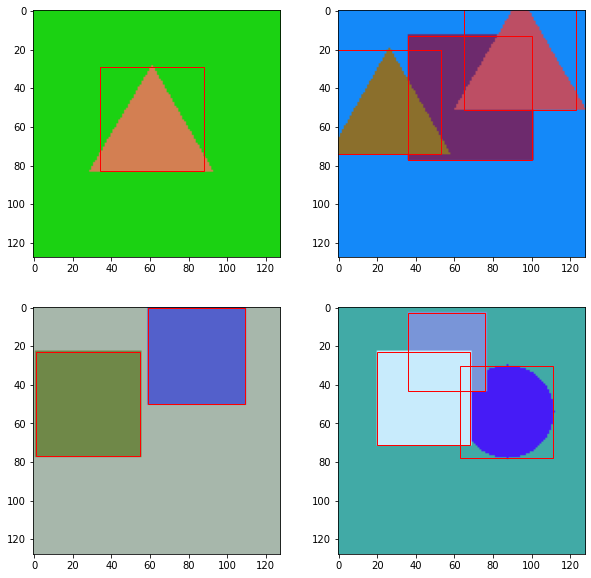

In [103]:
visualize(sample, target)


## Non-Maximal Supression
---
To visualize predictions from our model, we perform NMS on the final predictions to clear up the output. This is done as a lot of anchors near to the actual object will fire resulting in a lot of boxes. NMS handles these multiple predictions by merging and giving a single box for a predicted object instead of multiple. This is best shown through the following image.

![NMS](https://miro.medium.com/max/1000/0*WI5_K3bAbYaRyzE-.png)

## TODO 6 [25%]: Visualize
---

Now onto the final stretch! Your final task is to write code to visualize the model predictions on an image from the validation set. 


You will implement the `visualize_preds` function. This function will perform three subtasks.  
  (a). Select what anchors to draw on the image. Generally, if the foreground probability is > 0.7, it's a good idea to use the anchor.  
  (b). Adjust the anchors using the offsets. For this, you will need to _invert_ the `compute_offsets` function described above.  
Specifically, you will write the function `apply_offsets` that is related to `compute_offsets` in the following manner.
```
targets = apply_offsets(anchors, compute_offsets(targets, anchors))
```
  (c). Finally, you will use NMS to filter out anchors. You can use [`torchvision.ops.nms`](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html)

In [55]:
def apply_offsets(anchors, offsets):
    """
    This function appiles offsets to anchors and returns the result.
    Both anchors and offsets should be of the same shape, N x 4.
    offsets is the result from compute_offsets function.
    """
    # TODO: apply offsets to anchors
    a_width = anchors[:, 2] - anchors[:, 0]
    a_height = anchors[:, 3] - anchors[:, 1]
    a_center_x = anchors[:, 0] + 0.5 * a_width
    a_center_y = anchors[:, 1] + 0.5 * a_height 

    delta_x = offsets[:, 0]
    delta_y = offsets[:, 1]
    delta_scale_x = offsets[:, 2]
    delta_scale_y = offsets[:, 3]

    t_width = a_width / torch.exp(delta_scale_x)
    t_height = a_height / torch.exp(delta_scale_y)
    t_center_x = a_center_x - delta_x * t_width
    t_center_y = a_center_y - delta_y * t_height

    top_left_x = t_center_x - t_width * 0.5
    top_left_y = t_center_y - t_height * 0.5
    bottom_right_x = top_left_x + t_width
    bottom_right_y = top_left_y + t_height

    res = torch.cat([top_left_x.unsqueeze(0), top_left_y.unsqueeze(0), bottom_right_x.unsqueeze(0), bottom_right_y.unsqueeze(0)],
                dim=0)
    
    return res.permute(1, 0)    

In [56]:
# TEST the validity of your implementation of apply_offsets.
# create fake targets
top_left = torch.randint(128, [5, 2])
bottom_right = top_left + torch.randint(60, [5, 2])
# analogous to ground truth bounding boxes
targets_t = torch.cat([top_left, bottom_right], dim=1)

# create fake anchors
top_left = torch.randint(128, [5, 2])
bottom_right = top_left + torch.randint(60, [5, 2])
# analogous to best matching anchors
anchors_t = torch.cat([top_left, bottom_right], dim=1)

# check validity of apply_offsets
offsets_t = compute_offsets(targets_t, anchors_t)
pred_targets = apply_offsets(anchors_t, offsets_t)

# mask out nans, just in case
mask = pred_targets.isfinite()
pred_targets = pred_targets[mask]
targets_t = targets_t[mask].float()

# should return true
torch.allclose(pred_targets, targets_t)

True

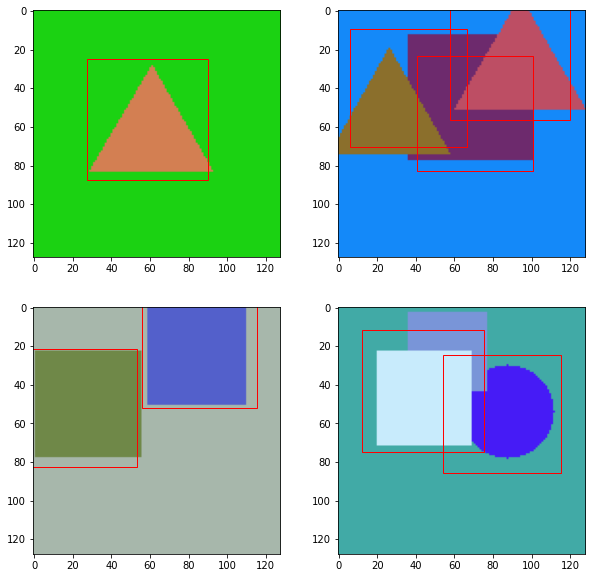

In [105]:
def visualize_preds(model, sample):
    model = model.to('cpu')

    label_preds, offset_preds = model(sample)

    # TODO: select foreground anchors, apply offsets and use NMS
    model.eval()
    gt_anchors = get_anchors()
    predictions = []
    iou_threshold = 0.3
    for i in range(sample.shape[0]):
      label_pred = torch.sigmoid(label_preds[i])
      offset_pred = offset_preds[i]
      box = gt_anchors[label_pred > 0.7]
      offset_pred = offset_pred[label_pred > 0.7]
      label_pred = label_pred[label_pred > 0.7]
      
      box = apply_offsets(box, offset_pred) 
      
      res = nms(box, label_pred, iou_threshold)
      predictions.append({'bounding_box' : box[res].data})
    
    visualize(sample, predictions)

visualize_preds(model, sample)

## Conclusion
---
Not bad, right ? This is a very barebones implementation and trained for a very short amount of epochs. However this is the gist of most anchor based state of the art detectors out today. We can improve accuracy by doing multiscale training and incorporating a Feature Pyramid Network amongst other things, but that is for you to discover :)

## References
---

Some foundational/good papers on object detection. This list is non exhaustive

1. [Single Shot Detector](https://arxiv.org/abs/1512.02325)
2. [YOLO](https://arxiv.org/abs/1612.08242)
3. [Faster RCNN](https://arxiv.org/abs/1506.01497)
4. [Feature Pyramid Network](https://arxiv.org/abs/1612.03144)
5. Bonus Read: [DETR- State of the art Object detector based on Transformers](https://arxiv.org/abs/2005.12872)
